In [4]:
#1 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from imblearn.over_sampling import SMOTE



In [5]:
#2 Load Dataset
df = pd.read_csv('/PS_20174392719_1491204439457_log.csv')
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668671 entries, 0 to 668670
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            668671 non-null  int64  
 1   type            668671 non-null  object 
 2   amount          668671 non-null  float64
 3   nameOrig        668671 non-null  object 
 4   oldbalanceOrg   668671 non-null  float64
 5   newbalanceOrig  668671 non-null  float64
 6   nameDest        668671 non-null  object 
 7   oldbalanceDest  668671 non-null  float64
 8   newbalanceDest  668671 non-null  float64
 9   isFraud         668670 non-null  float64
 10  isFlaggedFraud  668670 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 56.1+ MB
None

--- Summary Statistics ---
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  668671.000000  6.686710e+05   6.686710e+05    6.686710e+05   
mean       17.540438  1.629383e+05 

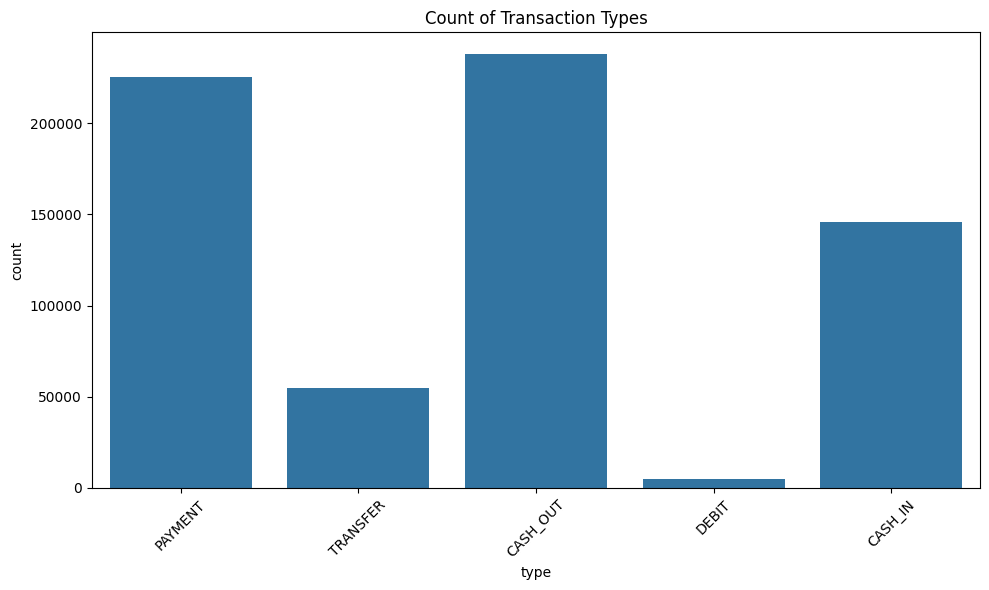

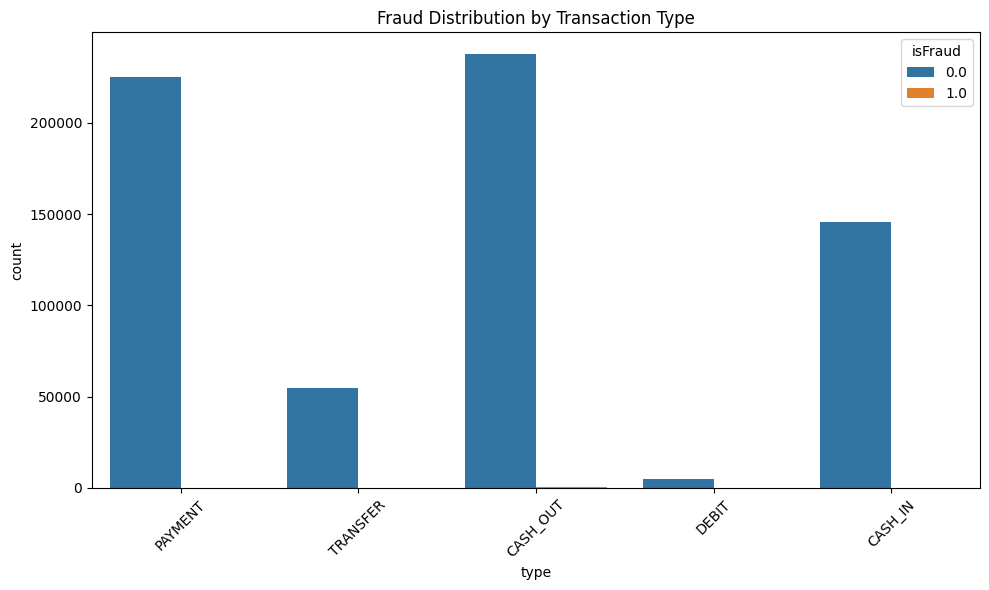

In [6]:
# 3. Exploratory Data Analysis (EDA)
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Class Distribution ---")
print(df['isFraud'].value_counts())
print(f"Fraud percentage: {df['isFraud'].mean() * 100:.4f}%")

# Visualize transaction types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Count of Transaction Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('transaction_types.png')

# Visualize fraud by transaction type
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Distribution by Transaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fraud_by_transaction_type.png')

In [7]:
# 4. Feature Engineering
# Extract features from nameOrig and nameDest.
# Customer accounts start with "C", merchant accounts start with "M"
# Seperating this can help us identify if Fraudsters prefer certain account types
df['originType'] = df['nameOrig'].str[0]
df['destType'] = df['nameDest'].str[0]

# Check balance changes
# A fraudulent transaction could completely empty an account therefore comparing the old and new balances are helpful.
df['origBalanceDelta'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['destBalanceDelta'] = df['newbalanceDest'] - df['oldbalanceDest']

# Check if transactions are "unusual" compared to account balance
# Fraudsters usually make transactions that are unusually large compared to typical activity.
df['origAmountToBalanceRatio'] = df['amount'] / (df['oldbalanceOrg'] + 0.001)  # Avoid division by zero

# Check hour of day for temporal patterns (assuming 'step' is in hours)
# Analyze if fraud happens more frequently on certain times of days
# e.g. middle of the night when most people would be asleep.
df['hourOfDay'] = df['step'] % 24

In [8]:
# 5. Data Preparation
# Define features and target
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Define categorical features
categorical_features = ['type', 'originType', 'destType']
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                      'oldbalanceDest', 'newbalanceDest', 'origBalanceDelta',
                      'destBalanceDelta', 'origAmountToBalanceRatio', 'hourOfDay']

# Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [10]:
# 6. Split the data
# After defining X and y, check for NaN values in y
print("\nChecking for NaN values in target variable:")
print(f"Number of NaN values in y: {y.isna().sum()}")

# Handle NaN values in y by dropping those rows
if y.isna().sum() > 0:
    print(f"Dropping {y.isna().sum()} rows with NaN values in the target variable")
    valid_indices = ~y.isna()
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"New shape of X: {X.shape}")
    print(f"New shape of y: {y.shape}")

# Now proceed with the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Checking for NaN values in target variable:
Number of NaN values in y: 1
Dropping 1 rows with NaN values in the target variable
New shape of X: (668670, 13)
New shape of y: (668670,)


In [11]:
# 7. Handle imbalanced data with SMOTE (only on training data)
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Resampled training data shape: {X_train_resampled.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Resampled class distribution: {pd.Series(y_train_resampled).value_counts(normalize=True)}")


Applying SMOTE to handle class imbalance...
Original training data shape: (534936, 13)
Resampled training data shape: (1069226, 18)
Original class distribution: isFraud
0.0    0.999396
1.0    0.000604
Name: proportion, dtype: float64
Resampled class distribution: isFraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [12]:
# 8. Build XGBoost Model
print("\nTraining XGBoost model...")
# Initial model with reasonable parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,  # We've balanced with SMOTE
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)


Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:02:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    133653
         1.0       0.04      0.93      0.08        81

    accuracy                           0.99    133734
   macro avg       0.52      0.96      0.54    133734
weighted avg       1.00      0.99      0.99    133734



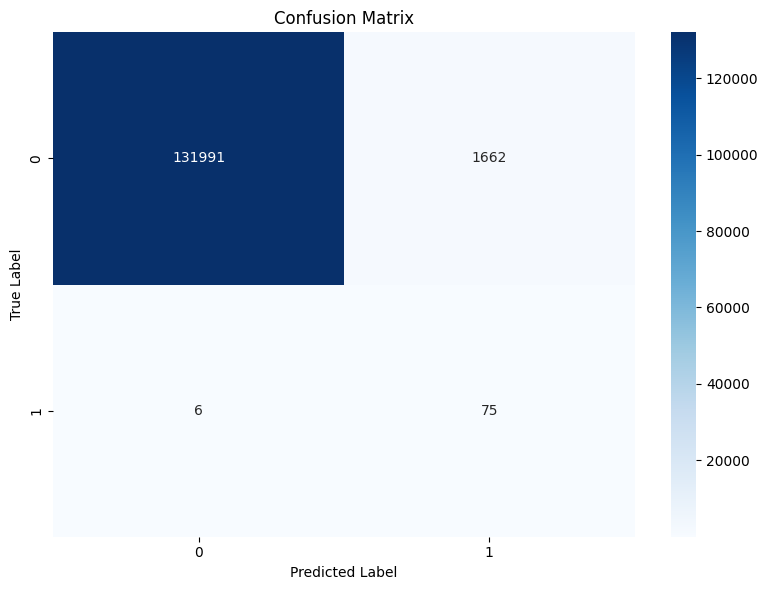

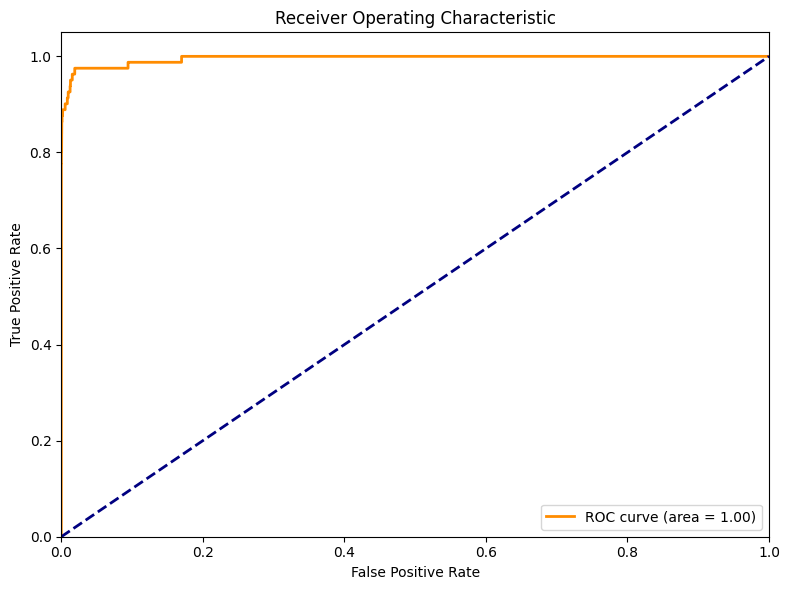

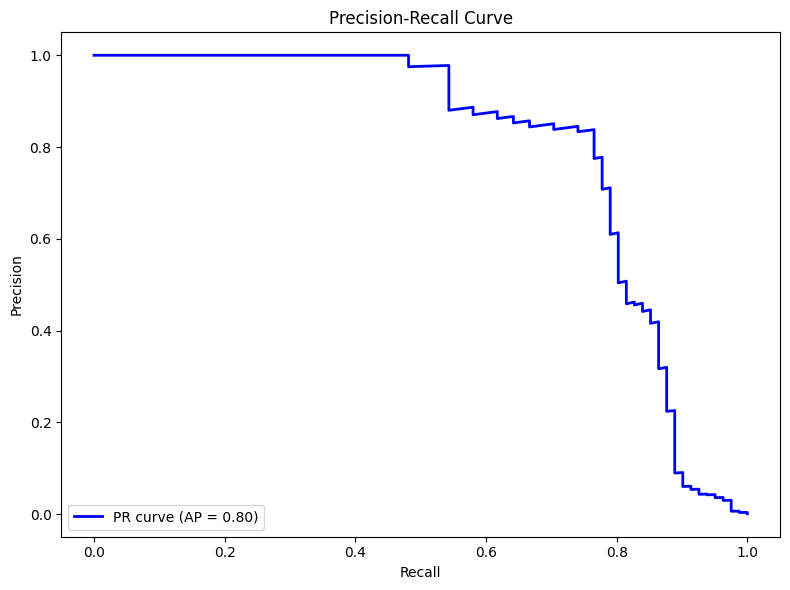

In [13]:
# 9. Model Evaluation
# Preprocess test data
X_test_preprocessed = preprocessor.transform(X_test)

# Make predictions
y_pred = xgb_model.predict(X_test_preprocessed)
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Print classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')

# Plot Precision-Recall curve (better for imbalanced datasets)
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig('precision_recall_curve.png')

**Overall accuracy 99% **= This looks good but is misleading. If the model predicted "no fraud" for all transactions it would achieve 99.94% accuracy.
**For legititamte transactions (Class 0):**
**Precision = 1.00**, when the model says a transaction is
legitimate it is always correct.
**Recall = 0.99**, the model correctly identifies 99% of legitimate transactions.
**For fraudulent transactions (class 1):**
Precision: 0.04, only 4% of fraudulent transactions flagged are actually fraudulent.
Recall: 0.93 - The model catches 93% of actual fraud

Business relevance:
The model is very good at catching fraud (93% detection rate)
However for every 100 transactions flagged as suspicious, only 4 are actual fraud (96 false alarms).
A good starting point, however due to the high false flags this could mean a lot of manual labour for employees to check actual fraudulent transactions.


In [ ]:
# Add to your imports
import os
import json

# Create a directory for outputs if it doesn't exist
output_dir = 'fraud_detection_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# After model evaluation, save results to CSV files for Power BI
# 1. Save predictions with probabilities
results_df = X_test.copy()
results_df['actual_fraud'] = y_test.values
results_df['predicted_fraud'] = y_pred
results_df['fraud_probability'] = y_pred_proba
results_df.reset_index(drop=True, inplace=True)
results_df.to_csv(f'{output_dir}/fraud_predictions.csv', index=False)
print(f"Prediction results saved to {output_dir}/fraud_predictions.csv")

# 2. Save confusion matrix data
cm_df = pd.DataFrame(cm,
                     index=['Actual_Non_Fraud', 'Actual_Fraud'],
                     columns=['Predicted_Non_Fraud', 'Predicted_Fraud'])
cm_df.to_csv(f'{output_dir}/confusion_matrix.csv')
print(f"Confusion matrix saved to {output_dir}/confusion_matrix.csv")

# 3. Save ROC curve data
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': _
})
roc_df.to_csv(f'{output_dir}/roc_curve.csv', index=False)
print(f"ROC curve data saved to {output_dir}/roc_curve.csv")

# 4. Save precision-recall curve data
pr_df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'threshold': np.append(_, [1.0])  # Add 1.0 to match length
})
pr_df.to_csv(f'{output_dir}/precision_recall_curve.csv', index=False)
print(f"Precision-recall curve data saved to {output_dir}/precision_recall_curve.csv")

# 5. Save feature importance
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
print(f"Feature importance saved to {output_dir}/feature_importance.csv")

# 6. Save model metrics as JSON
classification_metrics = classification_report(y_test, y_pred, output_dict=True)
metrics_dict = {
    'classification_report': classification_metrics,
    'auc_roc': roc_auc,
    'average_precision': avg_precision,
    'optimal_threshold': float(optimal_threshold)
}
with open(f'{output_dir}/model_metrics.json', 'w') as f:
    json.dump(metrics_dict, f)
print(f"Model metrics saved to {output_dir}/model_metrics.json")

# 7. Save sample transactions with predictions for dashboard examples
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
sample_results = results_df.iloc[sample_indices].copy()

# Add original transaction data
original_cols = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
                 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']
sample_data = df.loc[sample_results.index, original_cols].reset_index(drop=True)
sample_results = pd.concat([sample_data, sample_results[['actual_fraud', 'predicted_fraud', 'fraud_probability']]], axis=1)
sample_results.to_csv(f'{output_dir}/dashboard_sample_data.csv', index=False)
print(f"Sample data for dashboard saved to {output_dir}/dashboard_sample_data.csv")

# 8. Save transaction summary statistics
transaction_stats = df.groupby(['type', df['step'] // 24]).agg({
    'amount': ['count', 'sum', 'mean', 'max'],
    'isFraud': ['sum', 'mean']
}).reset_index()
transaction_stats.columns = ['transaction_type', 'day', 'count', 'total_amount', 'avg_amount', 'max_amount', 'fraud_count', 'fraud_rate']
transaction_stats.to_csv(f'{output_dir}/transaction_stats.csv', index=False)
print(f"Transaction statistics saved to {output_dir}/transaction_stats.csv")

<Figure size 1200x800 with 0 Axes>

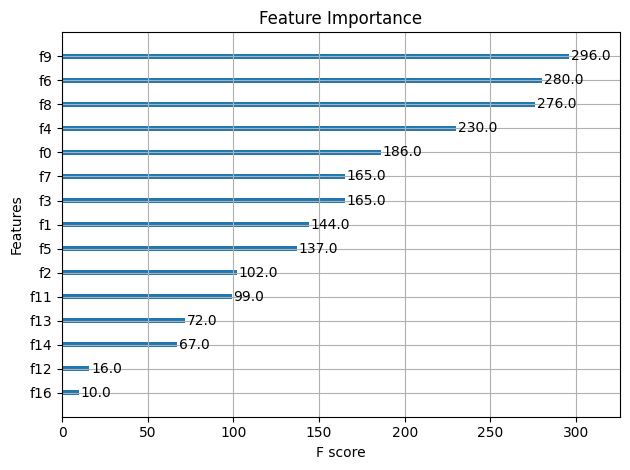

In [14]:
# 10. Feature Importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [15]:
# 11. Parameter Tuning with GridSearchCV (optional)
# Comment out or run as needed, as this can be time-consuming
'''
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)
print("\n--- Classification Report (Best Model) ---")
print(classification_report(y_test, y_pred))
'''

Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 

In [16]:
# 12. Finding optimal threshold for fraud detection
# Often in fraud detection, we may want to adjust the classification threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal probability threshold for classification: {optimal_threshold:.4f}")

# Apply optimal threshold and evaluate
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\n--- Classification Report (Optimal Threshold) ---")
print(classification_report(y_test, y_pred_optimal))



Optimal probability threshold for classification: 0.9824

--- Classification Report (Optimal Threshold) ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    133653
         1.0       0.84      0.77      0.80        81

    accuracy                           1.00    133734
   macro avg       0.92      0.88      0.90    133734
weighted avg       1.00      1.00      1.00    133734



In [17]:
# 13. Save the model
import pickle
model_path = 'fraud_detection_xgboost_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump((preprocessor, xgb_model, optimal_threshold), model_file)

print(f"\nModel saved to {model_path}")


Model saved to fraud_detection_xgboost_model.pkl


In [18]:
# 14. Function to make predictions on new data
def predict_fraud(new_data, model_path='fraud_detection_xgboost_model.pkl'):
    """
    Makes fraud predictions on new transaction data

    Parameters:
    -----------
    new_data : pandas DataFrame
        Data with the same structure as the training data
    model_path : str
        Path to the saved model

    Returns:
    --------
    pandas DataFrame with original data and predictions
    """
    # Load the model
    with open(model_path, 'rb') as model_file:
        preprocessor, model, threshold = pickle.load(model_file)

    # Create features if they don't exist
    if 'originType' not in new_data.columns:
        new_data['originType'] = new_data['nameOrig'].str[0]

    if 'destType' not in new_data.columns:
        new_data['destType'] = new_data['nameDest'].str[0]

    if 'origBalanceDelta' not in new_data.columns:
        new_data['origBalanceDelta'] = new_data['newbalanceOrig'] - new_data['oldbalanceOrg']

    if 'destBalanceDelta' not in new_data.columns:
        new_data['destBalanceDelta'] = new_data['newbalanceDest'] - new_data['oldbalanceDest']

    if 'origAmountToBalanceRatio' not in new_data.columns:
        new_data['origAmountToBalanceRatio'] = new_data['amount'] / (new_data['oldbalanceOrg'] + 0.001)

    if 'hourOfDay' not in new_data.columns:
        new_data['hourOfDay'] = new_data['step'] % 24

    # Preprocess the data
    features = new_data.drop(['nameOrig', 'nameDest'], axis=1, errors='ignore')
    X_new_preprocessed = preprocessor.transform(features)

    # Make predictions
    fraud_proba = model.predict_proba(X_new_preprocessed)[:, 1]
    fraud_pred = (fraud_proba >= threshold).astype(int)

    # Add predictions to the original data
    new_data['fraud_probability'] = fraud_proba
    new_data['fraud_prediction'] = fraud_pred

    return new_data

print("\nExample of using the prediction function:")
sample_transactions = df.sample(5)
results = predict_fraud(sample_transactions, model_path)
print(results[['type', 'amount', 'fraud_probability', 'fraud_prediction']])

print("\nFraud detection model complete!")


Example of using the prediction function:
            type     amount  fraud_probability  fraud_prediction
290865  TRANSFER  546759.23           0.002734                 0
100019   CASH_IN   87945.42           0.000396                 0
586657  CASH_OUT  151678.25           0.005830                 0
606885  TRANSFER  499143.19           0.002039                 0
253705   PAYMENT   12976.00           0.000499                 0

Fraud detection model complete!
